In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
stop_words = stopwords.words('english')


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

# Membaca dataset dari imdb.txt
df = pd.read_csv('imdb.txt', delimiter='\t', header=None)

# Memberi nama kolom baru
df.columns = ['Review', 'Rating']

# Mengkategorikan dataset berdasarkan nilai Rating (0 atau 1)
df['Category'] = df['Rating'].apply(lambda x: 'Negative' if x == 0 else 'Positive')

# Menambahkan tabel sesuai kategori
negative_reviews = df[df['Category'] == 'Negative']
positive_reviews = df[df['Category'] == 'Positive']

# Menggabungkan kedua tabel menjadi satu
combined_df = pd.concat([negative_reviews, positive_reviews])

# Menampilkan beberapa baris pertama dari tabel gabungan
print(combined_df.head())


                                              Review  Rating  Category
0  A very, very, very slow-moving, aimless movie ...       0  Negative
1  Not sure who was more lost - the flat characte...       0  Negative
2  Attempting artiness with black & white and cle...       0  Negative
3       Very little music or anything to speak of.         0  Negative
5  The rest of the movie lacks art, charm, meanin...       0  Negative


<Axes: xlabel='Rating', ylabel='count'>

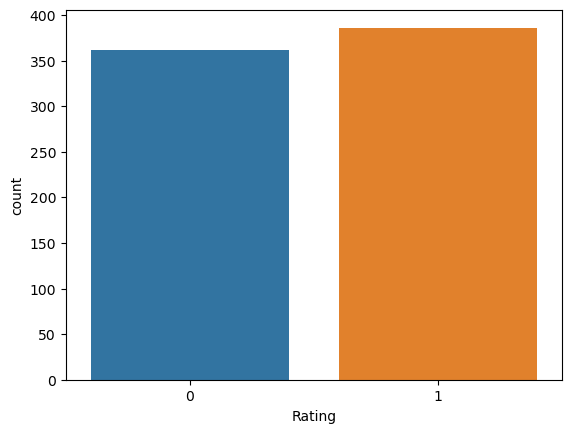

In [3]:
sns.countplot(x="Rating", data=df)

In [4]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [5]:
df['Review'] = df['Review'].apply(lambda x: clean_text(x))
 
df.head()

,Review,Rating,Category
0,"very, very, slow moving, aimless movie distres...",0,Negative
1,"sure lost flat character audience, nearly half...",0,Negative
2,attempting artiness black white clever camera ...,0,Negative
3,little music anything speak,0,Negative
4,best scene movie gerardo trying find song keep...,1,Positive


In [6]:
sample_corpora = df['Review'].iloc[:2].values
sample_corpora

array(['very, very, slow moving, aimless movie distressed, drifting young man',
       'sure lost flat character audience, nearly half walked'],
      dtype=object)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Your sample corpora
sample_corpora = ["This is the first document.",
                  "This document is the second document.",
                  "And this is the third one.",
                  "Is this the first document?"]

count_vectorizer = CountVectorizer()
wm = count_vectorizer.fit_transform(sample_corpora)

doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
feat_names = count_vectorizer.get_feature_names_out()

sample_df = pd.DataFrame(data=wm.toarray(), index=doc_names, columns=feat_names)
print(sample_df)


      and  document  first  is  one  second  the  third  this
Doc0    0         1      1   1    0       0    1      0     1
Doc1    0         2      0   1    0       1    1      0     1
Doc2    1         0      0   1    1       0    1      1     1
Doc3    0         1      1   1    0       0    1      0     1


In [8]:
X_train, X_test , y_train, y_test = train_test_split(df['Review'].values,df['Rating'].values,test_size=0.2,random_state=123,stratify=df['Rating'].values)

In [9]:
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)

tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

In [10]:
classifier = RandomForestClassifier()

classifier.fit(tfidf_train_vectors,y_train)

RandomForestClassifier()

In [11]:
y_pred = classifier.predict(tfidf_test_vectors)

In [12]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.55      0.66        73
           1       0.67      0.88      0.76        77

    accuracy                           0.72       150
   macro avg       0.74      0.72      0.71       150
weighted avg       0.74      0.72      0.71       150



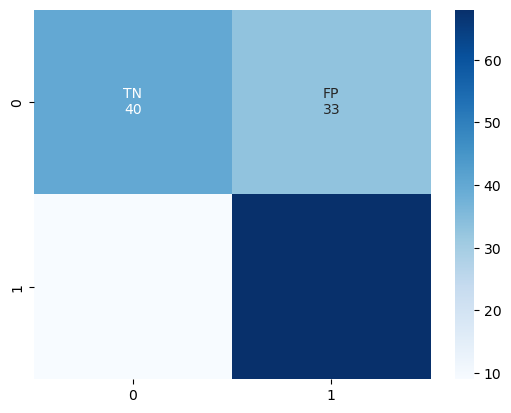

In [13]:
cnf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');